In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from scipy.interpolate import interpn
import pynbody

In [3]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'lvl5_test/'
s = pynbody.load(datadir+simulation+'snapdir_098/snapshot_098')

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:370: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [4]:
s['eps'] = s['smooth']
for key in s.families():
  s[key]['eps'] = s[key]['eps'].min()

In [5]:
h = s.halos()

In [6]:
transform = pynbody.analysis.angmom.faceon(h[1])

In [7]:
s.physical_units()

In [8]:
mask_clusters_initial = h[1].s['InitialNumberOfClusters'] > 0
mask_clusters_final = h[1].s['NumberOfClusters'] > 0

truncation_mass = h[1].s['ICMFTruncationMass'][mask_clusters_initial]
cluster_masses = h[1].s['ClusterMass'][mask_clusters_initial].flatten()
cluster_radius = h[1].s['ClusterRadius'][mask_clusters_initial].flatten()
init_cluster_masses = h[1].s['InitialClusterMass'][mask_clusters_initial].flatten()
init_cluster_radius = h[1].s['InitialClusterRadius'][mask_clusters_initial].flatten()
masslostrelax = h[1].s['MassLostRelaxation'][mask_clusters_initial].flatten()
masslostshock = h[1].s['MassLostShocks'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 2.01e+07 Msun
Maximum present-day mass 1.17e+07 Msun


In [9]:
clusters_birthtime = []
clusters_age = []
for i, nclt in enumerate(h[1].s['InitialNumberOfClusters'][mask_clusters_initial]):
  clusters_birthtime.append(np.ones(nclt) * h[1].s['tform'].in_units('Gyr')[mask_clusters_initial][i])
  clusters_age.append(np.ones(nclt) * h[1].s['age'].in_units('Gyr')[mask_clusters_initial][i])

clusters_birthtime = np.concatenate(clusters_birthtime)
clusters_age = np.concatenate(clusters_age)

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/analysis/cosmology.py:182: RuntimeWarning: invalid value encountered in log
  log_a_input = np.log(1./(1.+z))


In [10]:
clusters_disruptiontime = h[1].s['DisruptionTime'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]
disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)

/tmp/ipykernel_476433/538201836.py:3: RuntimeWarning: divide by zero encountered in divide
  disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)
/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/analysis/cosmology.py:182: RuntimeWarning: divide by zero encountered in log
  log_a_input = np.log(1./(1.+z))


In [11]:
lifetime_gyr = disruption_gyr - clusters_birthtime
lifetime_gyr[np.logical_not(disruption_gyr>0)] = 16

In [12]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>6)
veryold_mask = (clusters_age>10.)

In [13]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm='log', cmap=cm.viridis, **kwargs )

    return ax, h

In [14]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

In [15]:
# only because of a bug
cluster_masses[cluster_masses<0.] = 0.

Text(0, 0.5, 'Number')

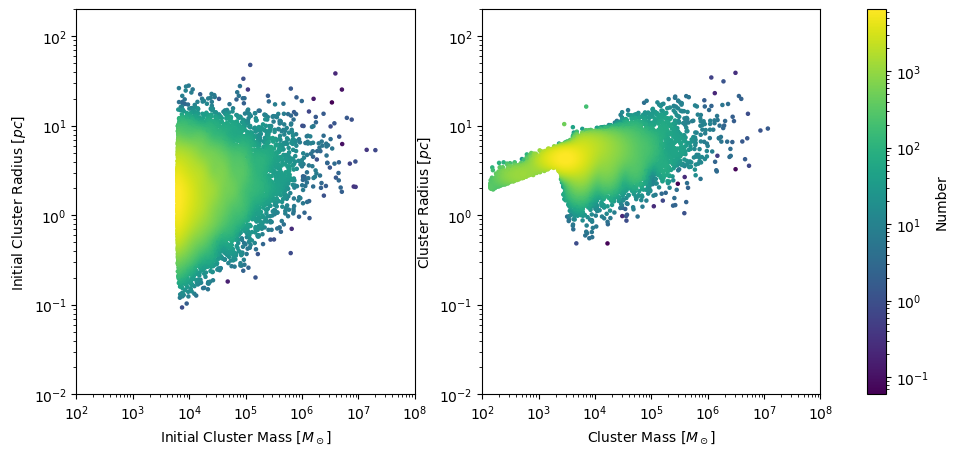

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses, init_cluster_radius*1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

ax[1], cb = density_scatter(cluster_masses, cluster_radius*1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')

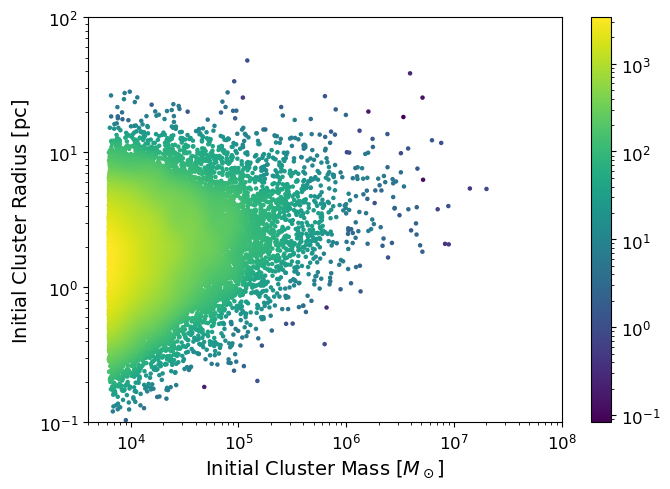

In [17]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax, cb = density_scatter(init_cluster_masses, init_cluster_radius*1e3, ax=ax,bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax.set(xscale='log', yscale='log', xlim=(4e3, 1e8), ylim=(1e-1, 1e2))
ax.set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [pc]', fontsize=14)
cbar = fig.colorbar(cb)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_rh.png')

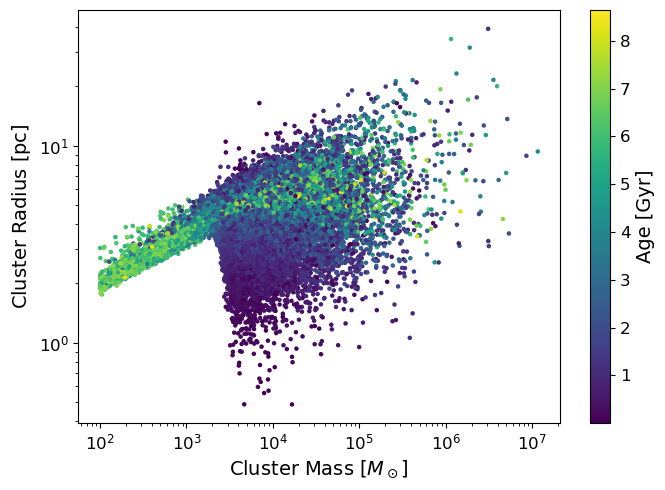

In [18]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
cb = ax.scatter(cluster_masses, cluster_radius*1e3, c=clusters_age, cmap=cm.viridis, s=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$\rm{Cluster}$ $\rm{Radius}$ [pc]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('final_mass_radius.png')

In [19]:
lossratio = masslostshock/masslostrelax

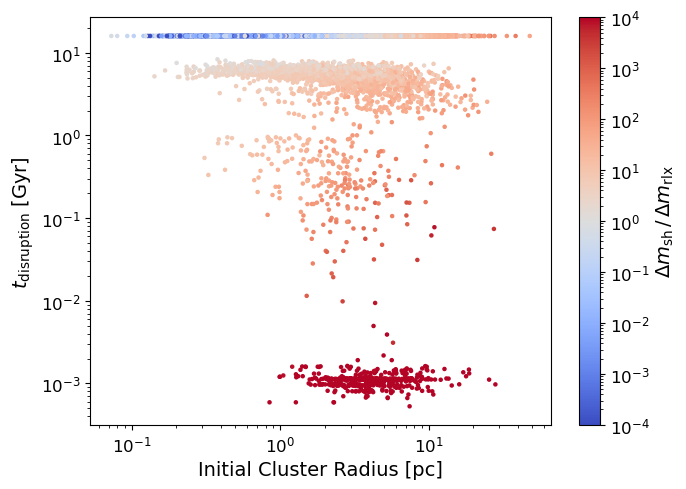

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_radius*1e3, lifetime_gyr, edgecolors='face', s=5, c=lossratio, cmap=cm.coolwarm, norm=colors.LogNorm(vmin=1e-4, vmax=1e4))
ax.set(xscale='log', yscale='log')#, xlim=(5e-2, 2e2), ylim=(1e-3, 2e1))
ax.set_xlabel('Initial Cluster Radius [pc]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label(r'$\Delta m_\mathrm{sh} \, / \, \Delta m_\mathrm{rlx}$', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('lifetime_radius.png')

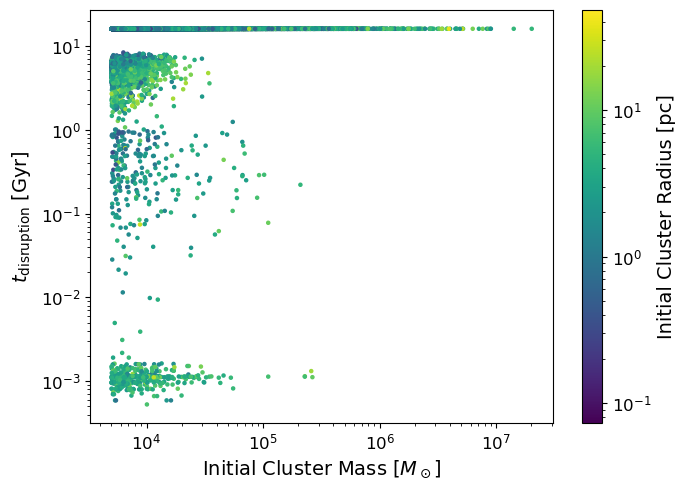

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_masses, lifetime_gyr, edgecolors='face', s=5, c=init_cluster_radius*1e3, cmap=cm.viridis, norm=colors.LogNorm())
ax.set(xscale='log', yscale='log')#, xlim=(4e3, 1e8), ylim=(1e-3, 2e1))
ax.set_xlabel(r'Initial Cluster Mass [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Initial Cluster Radius [pc]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_lifetime.png')

In [22]:
mw_rhdist = np.loadtxt('MW_rh.csv', delimiter=',')
m31_rhdist = np.loadtxt('M31_rh.csv', delimiter=',')
m83_rhdist = np.loadtxt('M83_rh.csv', delimiter=',')

emp_rhyoung = np.loadtxt('emp_young_rh.csv', delimiter=',')
emp_rh6gyr = np.loadtxt('emp_6gyr_rh.csv', delimiter=',')
emp_rh10gyr = np.loadtxt('emp_10gyr_rh.csv', delimiter=',')

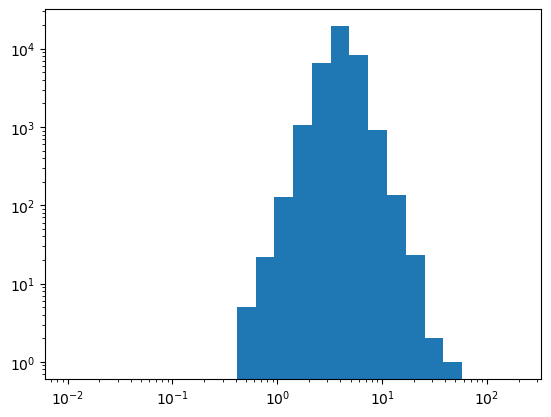

In [23]:
plt.hist(cluster_radius*1e3, bins=rharray)
plt.xscale('log')
plt.yscale('log')

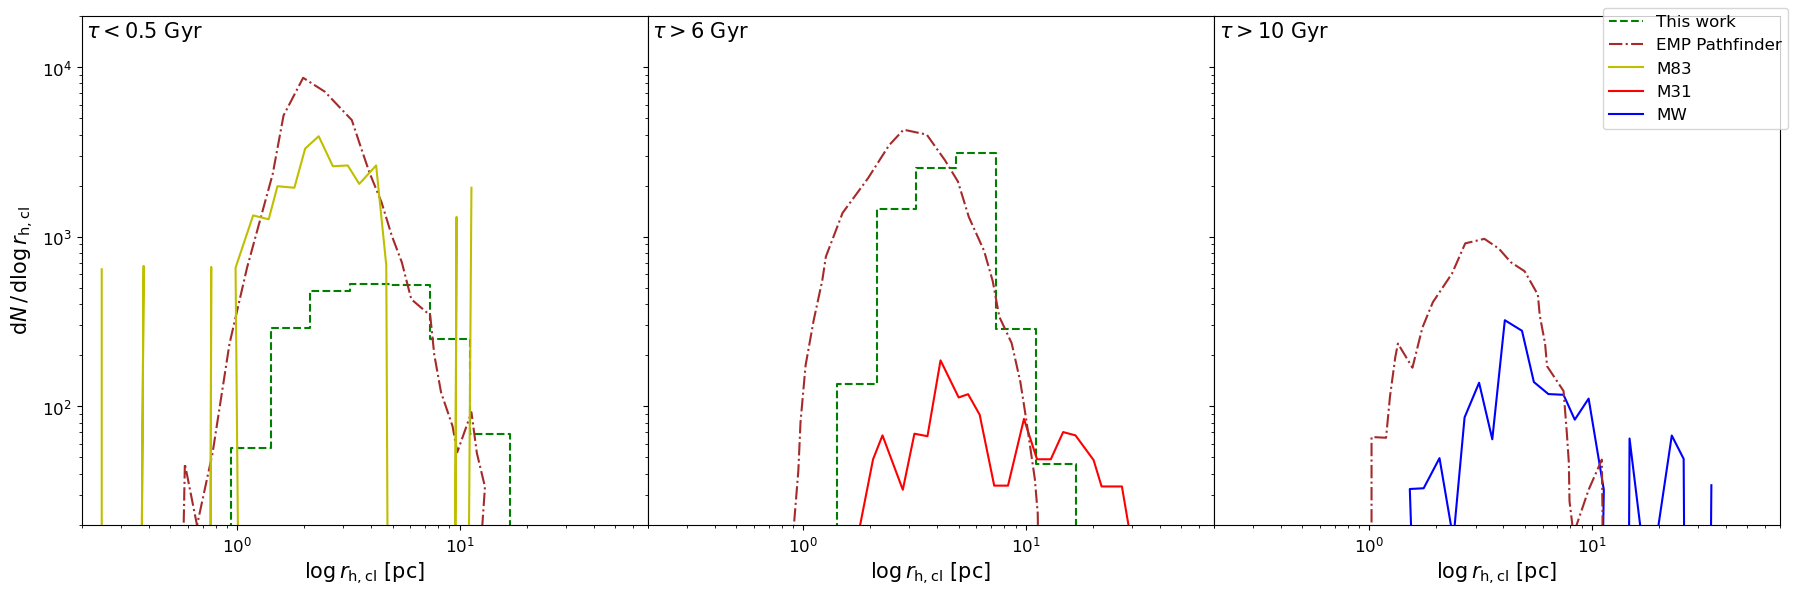

In [24]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,6))

N, _ = np.histogram(cluster_radius[young_mask]*1e3, bins=rharray)
ax[0].step(rharray[:-1], N*(rharray[1:] - rharray[:-1]), where='post', c='g', linestyle='dashed', label='This work')
ax[0].plot(emp_rhyoung[:,0], emp_rhyoung[:,1], linestyle='dashdot', c='brown', label='EMP Pathfinder')
ax[0].plot(m83_rhdist[:,0], m83_rhdist[:,1], c='y', label='M83')
ax[0].text(2.1e-1,1.5e4,r'$\tau < 0.5$ Gyr', fontsize=15)
ax[0].set(xlim=(2e-1,7e1), xscale='log')
ax[0].set_xlabel(r'$\log r_{\mathrm{h,cl}}$ [pc]', fontsize=15)
ax[0].set(ylim=(2e1,2e4), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log r_{\mathrm{h,cl}}$', fontsize=15)
ax[0].tick_params(labelsize=12)

N, _ = np.histogram(cluster_radius[old_mask]*1e3, bins=rharray)
ax[1].step(rharray[:-1], N*(rharray[1:] - rharray[:-1]), where='post', c='g', linestyle='dashed')
ax[1].plot(m31_rhdist[:,0], m31_rhdist[:,1], c='r', label='M31')
ax[1].plot(emp_rh6gyr[:,0], emp_rh6gyr[:,1], linestyle='dashdot', c='brown')
ax[1].text(2.1e-1,1.5e4,r'$\tau > 6$ Gyr', fontsize=15)
ax[1].set(xlim=(2e-1,7e1), xscale='log')
ax[1].set_xlabel(r'$\log r_{\mathrm{h,cl}}$ [pc]', fontsize=15)
ax[1].tick_params(labelsize=12)

N, _ = np.histogram(cluster_radius[veryold_mask]*1e3, bins=rharray)
ax[2].step(rharray[:-1], N*(rharray[1:] - rharray[:-1]), where='post', c='g', linestyle='dashed')
ax[2].plot(mw_rhdist[:,0], mw_rhdist[:,1], c='b', label='MW')
ax[2].plot(emp_rh10gyr[:,0], emp_rh10gyr[:,1], linestyle='dashdot', c='brown')
ax[2].text(2.1e-1,1.5e4,r'$\tau > 10$ Gyr', fontsize=15)
ax[2].set(xlim=(2e-1,7e1), xscale='log')
ax[2].set_xlabel(r'$\log r_{\mathrm{h,cl}}$ [pc]', fontsize=15)
ax[2].tick_params(labelsize=12)

fig.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('rh_distribution.png')

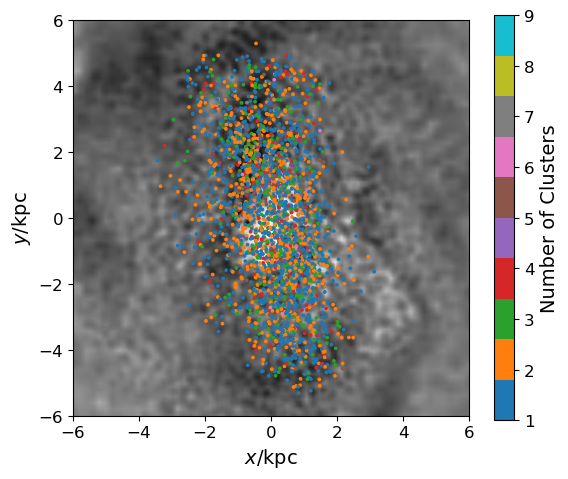

In [25]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
pynbody.plot.sph.image(h[1].g, qty='rho', units='Msol kpc^-2', width=12, cmap=cm.Greys, log=True, subplot=ax, show_cbar=False)
mask_mainhalo = (h[1].s['NumberOfClusters'] > 0) * (h[1].s['age'].in_units('Gyr') < 1)
cb = ax.scatter(h[1].s[mask_mainhalo]['x'], h[1].s[mask_mainhalo]['y'], c=h[1].s[mask_mainhalo]['NumberOfClusters'], s=3, cmap=cm.tab10)
cbar = fig.colorbar(cb, ax=ax).set_label('Number of Clusters')
fig.axes[1].tick_params(labelsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('cluster_distribution.png')